# Importing libraries and reading in file

In [30]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.classification import LinearSVC
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import NGram,HashingTF, IDF
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import lit
from pyspark.mllib.feature import StandardScaler, StandardScalerModel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.util import MLUtils
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Word2Vec

from pyspark import SparkContext

if __name__ == "__main__":
    spark = SparkSession\
        .builder\
        .appName("Detecting-Malicious-URL App")\
        .getOrCreate()

#Reading in the URL file and storing into dataframe
raw_data = spark.read.csv(path='processed_data/kaggle_dataset.csv',
                        sep=',',
                        encoding='UTF-8',
                        comment=None,
                        header=True, 
                        inferSchema=True)

#Uncomment the following two lines if kaggle datasets is used...and replace data_df variable above with raw_data
indexer = StringIndexer(inputCol="lable", outputCol="label")
data_df = indexer.fit(raw_data).transform(raw_data).select("url", "label")

#Check whether the dataset is balanced of unblanced
data_df.groupby('label').count().toPandas()

,label,count
0,0.0,344821
1,1.0,75643


# Under Sample Unbalanced Datasets

In [31]:

malicious = data_df.filter("label = 1")
bening = data_df.filter("label = 0")

#malicious.count()
#bening.count()

sampleRatio = malicious.count() / data_df.count()
#print("sampleRatio: %g" %sampleRatio)
sample_bening = bening.sample(False, sampleRatio)

sampled = malicious.unionAll(sample_bening)

sampled.groupby('label').count().toPandas()



,label,count
0,0.0,62038
1,1.0,75643


# Data Ingestion and Vectorization

In [32]:
#Tokennize the TrainData - sparse the URL string into words
regexTokenizer = RegexTokenizer(inputCol="url", outputCol="Words", pattern="\\W")

#determing components to be removed in the URL
add_stopWords = ["http", "https", "www", "ftp"]

#Removing the above stop words  from the tokenized data
stopwordsRemover = StopWordsRemover(inputCol=regexTokenizer.getOutputCol(), outputCol="Filtered").setStopWords(add_stopWords)

#Convert the words to ngrams. Note: this is not used in production as it gives less results during model training
ngram = NGram(n=3, inputCol=stopwordsRemover.getOutputCol(), outputCol="Ngrams")

#Word2Vec - Note: this is not used in production as it gives less results during model training
word2Vec = Word2Vec(vectorSize=1000, minCount=5, inputCol=stopwordsRemover.getOutputCol(), outputCol="features")

#Hashing the data - Note: this is not used in production as it gives less results during model training
hashingTF = HashingTF(inputCol=ngram.getOutputCol(), outputCol="rawFeatures")

#Note: this is not used in production as it gives less results during model training
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features") 

#CountVectorizer converts the the words into feature vectors - Thi is used as it gives better results
countVectors = CountVectorizer(inputCol=stopwordsRemover.getOutputCol(), outputCol="features", vocabSize=10000, minDF=5)

#creating the pipepline of steps to be performed in order
pipeline = Pipeline(stages=[regexTokenizer,stopwordsRemover, countVectors ])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(sampled)

#Transform the pipeline to dataset
dataset = pipelineFit.transform(sampled)

#randomly split the dataset to traning and testing 80%, 20% respectively
(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 48)
print("\nTraining Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))
print("Total Dataset Count: " + str(dataset.count()))

dataset.toPandas()


Training Dataset Count: 110078
Test Dataset Count: 27603
Total Dataset Count: 137681


,url,label,Words,Filtered,features
0,diaryofagameaddict.com,1.0,"[diaryofagameaddict, com]","[diaryofagameaddict, com]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,espdesign.com.au,1.0,"[espdesign, com, au]","[espdesign, com, au]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,iamagameaddict.com,1.0,"[iamagameaddict, com]","[iamagameaddict, com]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,kalantzis.net,1.0,"[kalantzis, net]","[kalantzis, net]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
4,slightlyoffcenter.net,1.0,"[slightlyoffcenter, net]","[slightlyoffcenter, net]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
5,toddscarwash.com,1.0,"[toddscarwash, com]","[toddscarwash, com]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,tubemoviez.com,1.0,"[tubemoviez, com]","[tubemoviez, com]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,ipl.hk,1.0,"[ipl, hk]","[ipl, hk]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,crackspider.us/toolbar/install.php?pack=exe,1.0,"[crackspider, us, toolbar, install, php, pack,...","[crackspider, us, toolbar, install, php, pack,...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,pos-kupang.com/,1.0,"[pos, kupang, com]","[pos, kupang, com]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [33]:
testData.groupby('label').count().toPandas()

,label,count
0,0.0,12315
1,1.0,15288


# Logistic Regression


Root Mean Squared Error (RMSE) on test data = 0.277461

Accuracy on Test Data = 98.4234

Average Accuracy on test for 1 run is: 98.4234
Test: Area Under ROC: 0.9842343847498695
Test: Area Under PR - precision-recall curve: 0.9877782809120871
Precision 92.2477
Recall 92.2477


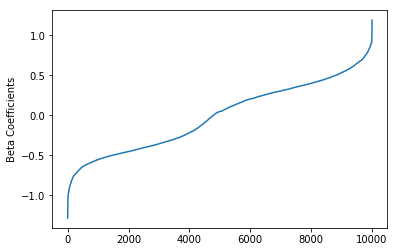

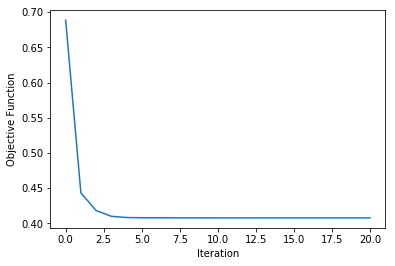

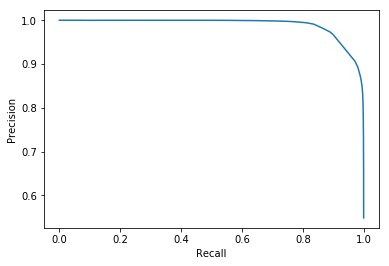

areaUnderROC: 0.9870134932414982
+---------------+---------------+
|            FPR|            TPR|
+---------------+---------------+
|            0.0|            0.0|
|            0.0|0.0129401043...|
|            0.0|0.0268577582...|
|            0.0|0.0408416866...|
|            0.0|0.0548918896...|
|            0.0|0.0692900339...|
|2.0111417251...|0.0851959241...|
|2.0111417251...|0.1056084831...|
|2.0111417251...|0.1229392759...|
|2.0111417251...|0.1256896694...|
+---------------+---------------+
only showing top 10 rows



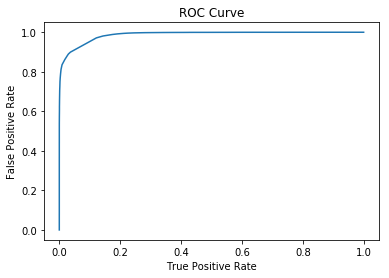

+---------------+---------------+
|      threshold|      F-Measure|
+---------------+---------------+
|0.9991238505...|0.0255495943...|
|0.9740266107...|0.0523105718...|
|0.9623905706...|0.0784781916...|
|0.9523269024...|0.1040711189...|
|0.9430645468...|0.1296000743...|
|0.9352003056...|0.1570124278...|
|0.9279441097...|0.1910385134...|
|0.9208752268...|0.2189565627...|
|0.9148520655...|0.2233081157...|
|0.9139898081...|0.2498912633...|
+---------------+---------------+
only showing top 10 rows



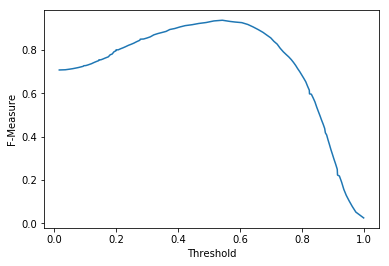

In [34]:
#==============[ LOGISTIC REGRESSION ]=========================
accuracy = 0.0
average_accuracy = 0.0


# Build logistic regresssion model
for i in range(1,2):
    # Fit the pipeline to training documents.
    pipelineFit = pipeline.fit(sampled)

    #Transform the pipeline to dataset
    dataset = pipelineFit.transform(sampled)
    
    #randomly split the dataset to traning and testing 80%, 20% respectively
    (trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 48)
    
    lr = LogisticRegression(maxIter=10000, regParam=0.3, elasticNetParam=0, family = "binomial")
    # Train model using logisitic regression
    lrModel = lr.fit(trainingData)

#Doing the prediction using test data
#Label is not used in test data
    predictions = lrModel.transform(testData)

  #  predictions.select("url", "label", "prediction").show(n=5, truncate = 100)
# Select (prediction, true label) and compute test error
    evaluator = RegressionEvaluator(
        labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print("\nRoot Mean Squared Error (RMSE) on test data = %g" % rmse)

    # Evaluate model
    evaluator = BinaryClassificationEvaluator()
    accuracy = evaluator.evaluate(predictions)
    
    average_accuracy = accuracy + average_accuracy

    print("\nAccuracy on Test Data = %g" % (accuracy*100))
    
   # print("test accuracy with pipeline " + accuracyScore(lrModel.transform(testData), "label", "prediction"))
    #print("test recall for 1.0 is " + recall(lrModel.transform(testData), "label", "prediction", 1))

average_accuracy = average_accuracy/i    
print("\nAverage Accuracy on test for %i run is: %g" % (i, (average_accuracy *100)))
#evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
print("Test: Area Under PR - precision-recall curve: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})))

evaluator_p = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
precision = evaluator_p.evaluate(predictions,{evaluator.metricName: "precision"})
print("Precision %g" % (precision *100))

evaluator_r = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
recall = evaluator_r.evaluate(predictions,{evaluator.metricName: "recall"})
print("Recall %g" % (recall*100))

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

# Extract the summary from the returned LogisticRegressionModel instance trained
trainingSummary = lrModel.summary

#Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.show()

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

trainingSummary.roc.show(n=10, truncate=15)
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#Set the model threshold to maximize F-Measure
trainingSummary.fMeasureByThreshold.show(n=10, truncate = 15)
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()




#predictions.filter(predictions['prediction'] == 0) \
#    .select("url", "label","prediction") \
#    .orderBy("probability", ascending=False) \
#    .show(n = 10, truncate = 80)
#Precision measures the percentage of URLs flagged as malicious that were correctly classified
#Recall measures the percentage of actual Malicious URLs that were correctly classified

# Cross Validation for Logistic Regression

In [35]:
#==============[ Cross Validation for Logistic Regression ]=====================
# Creating ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
#            .addGrid(model.maxIter, [10, 20, 50]) #Number of iterations
#            .addGrid(idf.numFeatures, [10, 100, 1000]) # Number of features
             .build())

# Create 10-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)

# Run cross validations
cvModel = cv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

# Use test set here so we can measure the accuracy of our model on new data
predictions = cvModel.transform(testData)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

evaluator_p = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
precision = evaluator_p.evaluate(predictions,{evaluator.metricName: "precision"})
print("Precision %g" % (precision *100))

evaluator_r = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
recall = evaluator_r.evaluate(predictions,{evaluator.metricName: "recall"})
print("Recall %g" % (recall*100))



Test: Area Under ROC: 0.9851610401179736
Precision 92.5543
Recall 92.5543


# Linear Support Vector Machine

In [36]:
#==============[ Linear Support Vector Machine ]=====================

for i in range(1, 2):
    
     # Fit the pipeline to training documents.
    pipelineFit = pipeline.fit(data_df)

    #Transform the pipeline to dataset
    dataset = pipelineFit.transform(data_df)
    
    #randomly split the dataset to traning and testing 80%, 20% respectively
    (trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 100)

    lsvc = LinearSVC(maxIter=10, regParam=0.3)

    # Fit the model
    lsvcModel = lsvc.fit(trainingData)

    predictions = lsvcModel.transform(testData)

    #predictions.select("url", "label", "prediction").show(n=5, truncate = 100)

    # Select (prediction, true label) and compute test error
    evaluator = RegressionEvaluator(
        labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

    # Evaluate model
    evaluator = BinaryClassificationEvaluator()
    accuracy = evaluator.evaluate(predictions)

    print("\nAccuracy on Test Data = %g" % (accuracy*100))
    evaluator_p = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    precision = evaluator_p.evaluate(predictions,{evaluator.metricName: "precision"})
    print("Precision %g" % (precision *100))

    evaluator_r = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    recall = evaluator_r.evaluate(predictions,{evaluator.metricName: "recall"})
    print("Recall %g" % (recall*100))


Root Mean Squared Error (RMSE) on test data = 0.237822

Accuracy on Test Data = 97.5476
Precision 93.9501
Recall 93.9501


# One-vs-Rest Classifier ( a.k.a One-vs-All

In [37]:
#==============[ One-vs-Rest classifier (a.k.a. One-vs-All ]=====================

for i in range(1, 2):
    
     # Fit the pipeline to training documents.
    pipelineFit = pipeline.fit(data_df)

    #Transform the pipeline to dataset
    dataset = pipelineFit.transform(data_df)
    
    #randomly split the dataset to traning and testing 80%, 20% respectively
    (trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 100)

    # instantiate the base classifier.
    lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)

    # instantiate the One Vs Rest Classifier.
    ovr = OneVsRest(classifier=lr)

    # train the multiclass model.
    ovrModel = ovr.fit(trainingData)

    # score the model on test data.
    predictions = ovrModel.transform(testData)

    # obtain evaluator.
    evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

 #   rec = MulticlassClassificationEvaluator(metricName="weightedPrecision")
 
  #  predictions.select("url", "label", "prediction").show(n=5, truncate = 100)


    # compute the classification error on test data.
    accuracy = evaluator.evaluate(predictions)
    print("Test Error = %g" % (1.0 - accuracy))
    print("\nAccuracy on Test Data = %g" % (accuracy*100))
    
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Accuracy = %g" % (accuracy*100))

    evaluatorf1 = MulticlassClassificationEvaluator( predictionCol="prediction", metricName="f1")
    f1 = evaluatorf1.evaluate(predictions)
    print("f1 = %g" % (f1*100))
 
    evaluatorwp = MulticlassClassificationEvaluator(predictionCol="prediction", metricName="weightedPrecision")
    wp = evaluatorwp.evaluate(predictions)
    print("weightedPrecision = %g" % (wp*100))
 
    evaluatorwr = MulticlassClassificationEvaluator( predictionCol="prediction", metricName="weightedRecall")
    wr = evaluatorwr.evaluate(predictions)
    print("weightedRecall = %g" % (wr*100))
    
    evaluator_r = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    recall = evaluator_r.evaluate(predictions,{evaluator.metricName: "recall"})
    print("Recall %g" % (recall*100))

    evaluator_p = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    precision = evaluator_p.evaluate(predictions,{evaluator.metricName: "precision"})
    print("Precision %g" % (precision *100))

Test Error = 0.0389889

Accuracy on Test Data = 96.1011
Accuracy = 96.1011
f1 = 96
weightedPrecision = 96.0636
weightedRecall = 96.1011
Recall 96
Precision 96
